In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%pip install teeplot
from teeplot import teeplot as tp
from scipy.stats import kruskal
from IPython.display import display





# OSF identifier
data_id = "v3ec9"

# load CSV file into DataFrame directly from OSF URL
df = pd.read_csv(f"https://osf.io/{data_id}/download")


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


,Algorithm,H-statistic,p-value
0,steady,1.335,0.513032
1,stretched,0.326,0.849665
2,tilted,2.456,0.292811


teeplots/hue=s+viz=plot-mean-real-execution-time+x=algorithm+y=real-time-per-site-ns+ext=.pdf
teeplots/hue=s+viz=plot-mean-real-execution-time+x=algorithm+y=real-time-per-site-ns+ext=.png


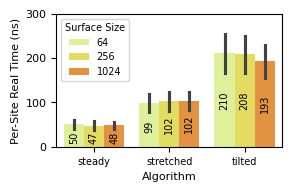

In [2]:
def plot_mean_real_execution_time(data, **kwargs):
    df["algorithm"] = df["Algorithm"].replace({
        "steady_lookup_ingest_times_batched": "steady",
        "stretched_lookup_ingest_times_batched": "stretched",
        "tilted_lookup_ingest_times_batched": "tilted",
    })

    # assign S and Tsize directly
    df["S"] = df["Surface Size (S)"]
    df["Tsize"] = df["T Size"]

    # convert to microseconds per site
    df["Real Time Per Site (ns)"] = (df["Real Execution Time"] * 1e9) / (df["S"] * df["Tsize"])

    # group by algorithm, S and compute mean per-site time
    # grouped = df.groupby(["algorithm", "S"], as_index=False)["Real Time Per Site (ns)"].mean()

    # work off the same data
    kruskal_results = []
    for algo, grp in df.groupby("algorithm"):
        # gather each surface-size’s samples
        samples = [g["Real Time Per Site (ns)"].values for _, g in grp.groupby("S")]
        if len(samples) > 1:
            stat, p_val = kruskal(*samples)
        else:
            stat, p_val = float('nan'), float('nan')
        kruskal_results.append({
            "Algorithm": algo,
            "H-statistic": round(stat, 3) if pd.notna(stat) else stat,
            "p-value": p_val
        })
    display(pd.DataFrame(kruskal_results))

    # bar plot
    plt.figure(figsize=(3, 2))  # these are IRL dimensions

    # more bar plot
    ax = sns.barplot(data=data, **kwargs, alpha=0.85, palette='Wistia')

    # add labels to the bars
    for container in ax.containers:
      for bar in container:
          height = bar.get_height()
          label = f"{int(height)}" if height > 0 else ""
          x = bar.get_x() + bar.get_width() / 2
          y = bar.get_y()

          # Calculate bar center
          center_y = y + height / 2

          # Use x-position to guess algorithm name (assuming order is steady, stretched, tilted)
          alg_x = x
          if alg_x < 1:  # usually 'steady' bars are first
              offset = -4  # nudge down a bit
          else:
              offset = 0  # normal center

          ax.text(
              x, center_y + offset, label,
              ha='center', va='center', fontsize=7, rotation=90
          )


    # better readability
    plt.xlabel("Algorithm", fontsize=8)
    plt.ylabel("Per-Site Real Time (ns)", fontsize=8)

    # keep x-axis labels horizontal
    plt.xticks(fontsize=7, rotation=0)

    plt.yticks(fontsize=8)

    # ylim
    ax.set_ylim(0, 300)

    # legend
    plt.legend(title="Surface Size", title_fontsize=7, fontsize=7, loc="upper left")

    # layout adjustment
    plt.subplots_adjust(bottom=0.4)
    plt.tight_layout(pad=1)

# teeplot
tp.tee(plot_mean_real_execution_time, data=df, x="algorithm", y="Real Time Per Site (ns)", hue="S")
